In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from scipy import signal as sg

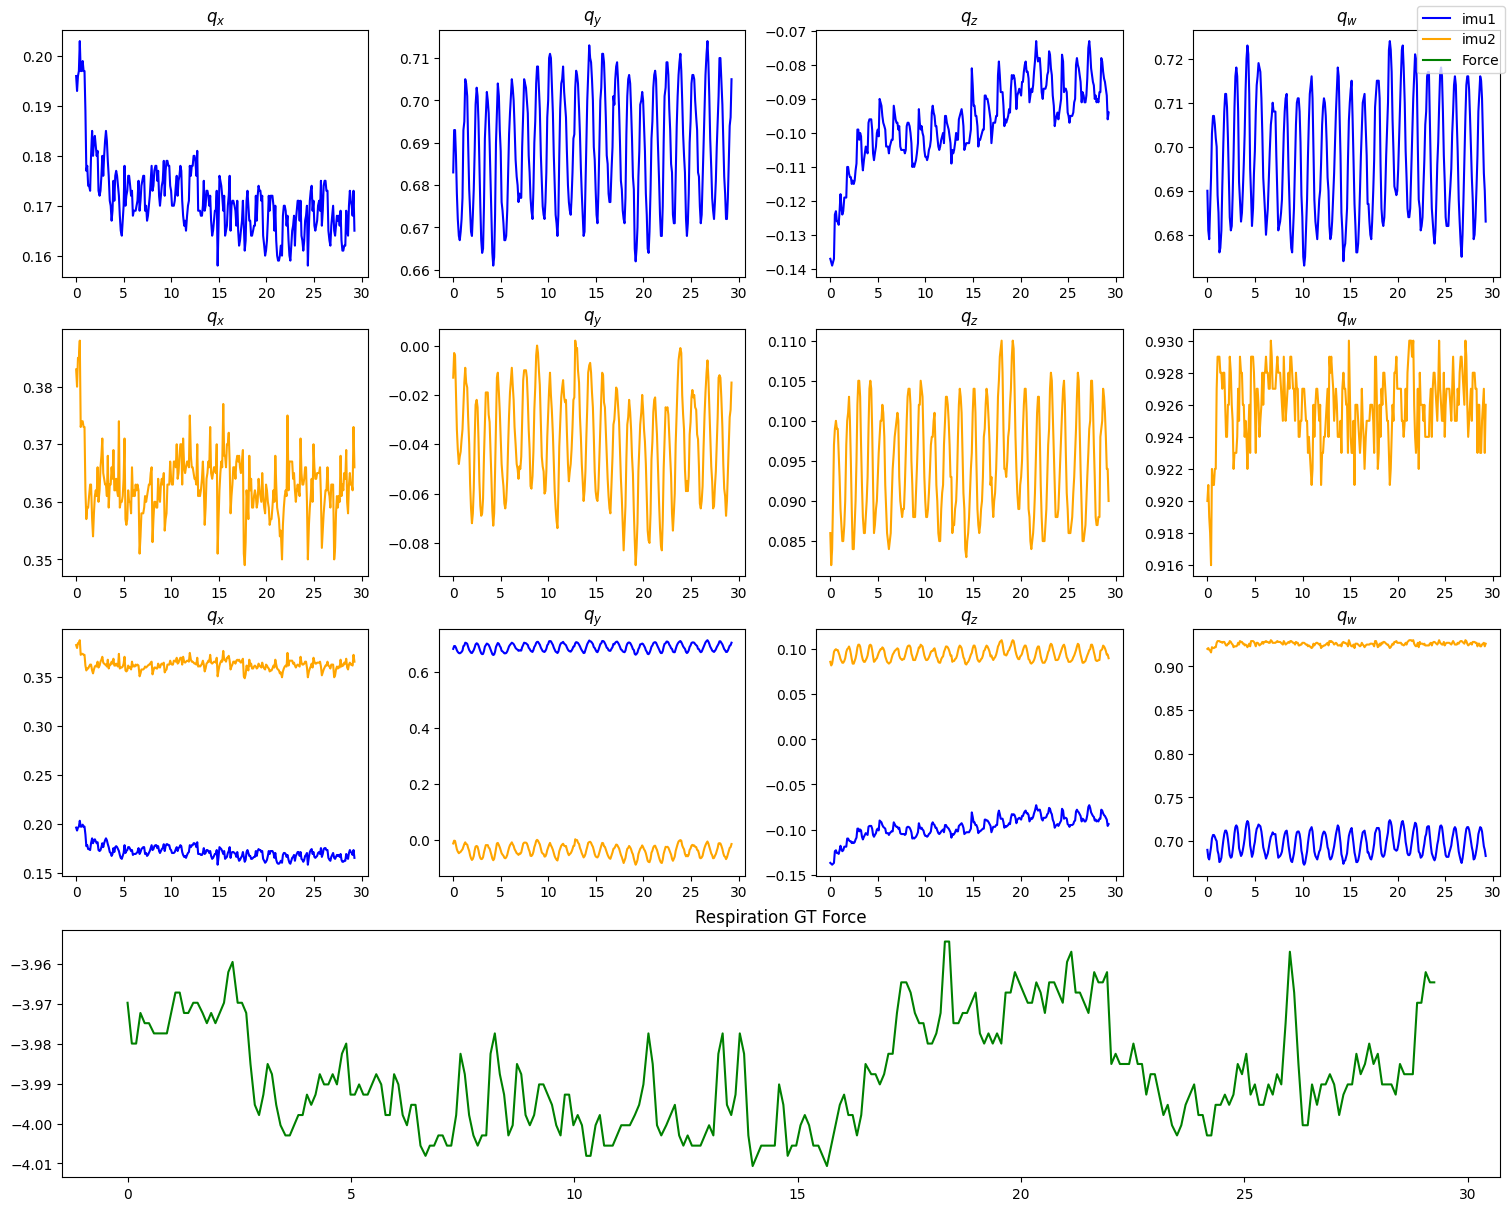

In [53]:
fs = 10
# start_pt, end_pt = 50, -30 # 50, -50
start_pt, end_pt = 50, 350

file_path = "./data/2_27/skew_2.csv"  # ./data/12_25/stand_2.csv, ./data/1_19/stand2walk_2.csv, ./data/2_22/stick_1.csv
# ./data/2_20/stand_2.csv, ./data/2_20/walk_stand_2.csv, ./data/2_20/stand2walk_3.csv, ./data/2_20/stand2wobbleLR_3.csv, ./data/2_20/stand2wobbleFB_1.csv
# Euler
# ./data/2_20/stand2walk_2.csv
# ./data/2_26/sit_1.csv, ./data/2_26/stand_1.csv, ./data/2_26/walk_stand_1.csv, ./data/2_26/stand2walk_1.csv

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

# shift to 0
# for k, key in enumerate(sensor_names):
#      for i in range(len(cols)):
#           data[key + "_" + cols[i]] = data[key + "_" + cols[i]] - np.mean(data[key + "_" + cols[i]])

data = data.iloc[start_pt:end_pt]

draw_imu_curve(data, overlap=True, show_gt=True)

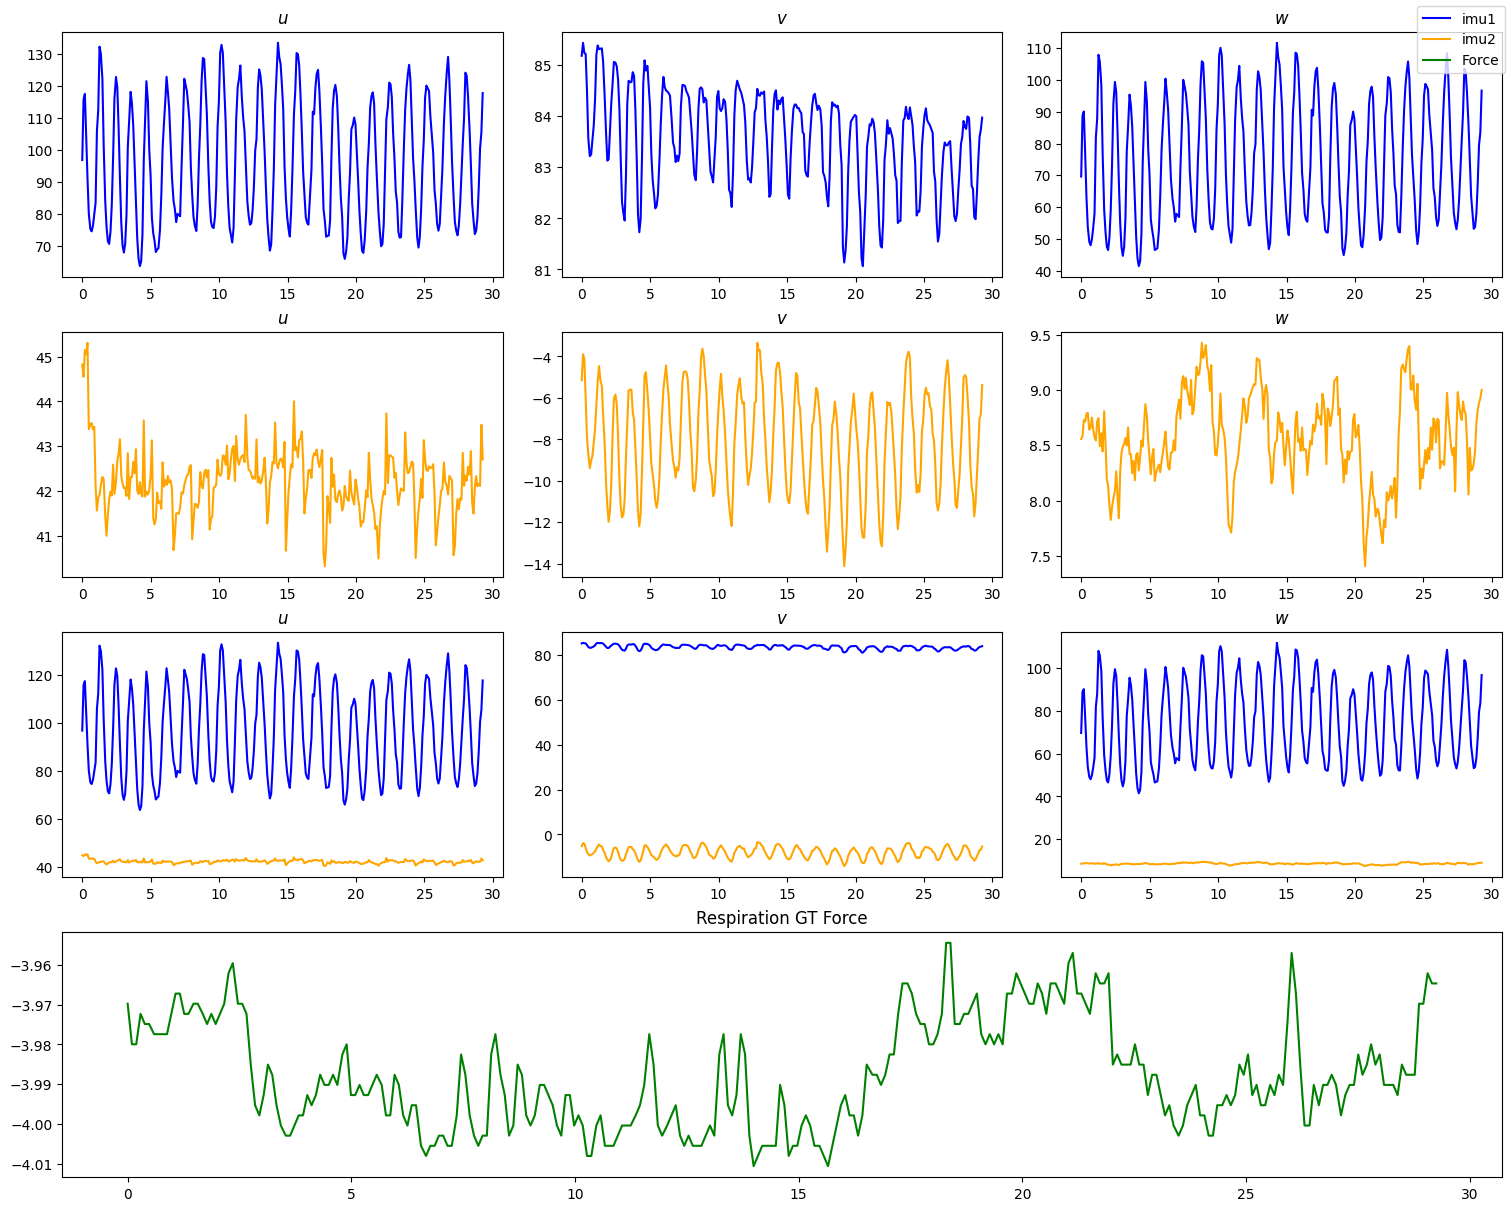

In [55]:
euler_axes = ['u', 'v', 'w']
euler_angles = {}
for imu in sensor_names:
    q = data[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values
    u, v, w = quaternion_to_euler(q)
    euler_angle = [u, v, w]
    # euler_angle = [u - np.mean(u), v - np.mean(v), w - np.mean(w)]
    for i, euler_axis in enumerate(euler_axes):
        euler_angles[imu + "_" + euler_axis] = euler_angle[i]

draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=True)

# LMS

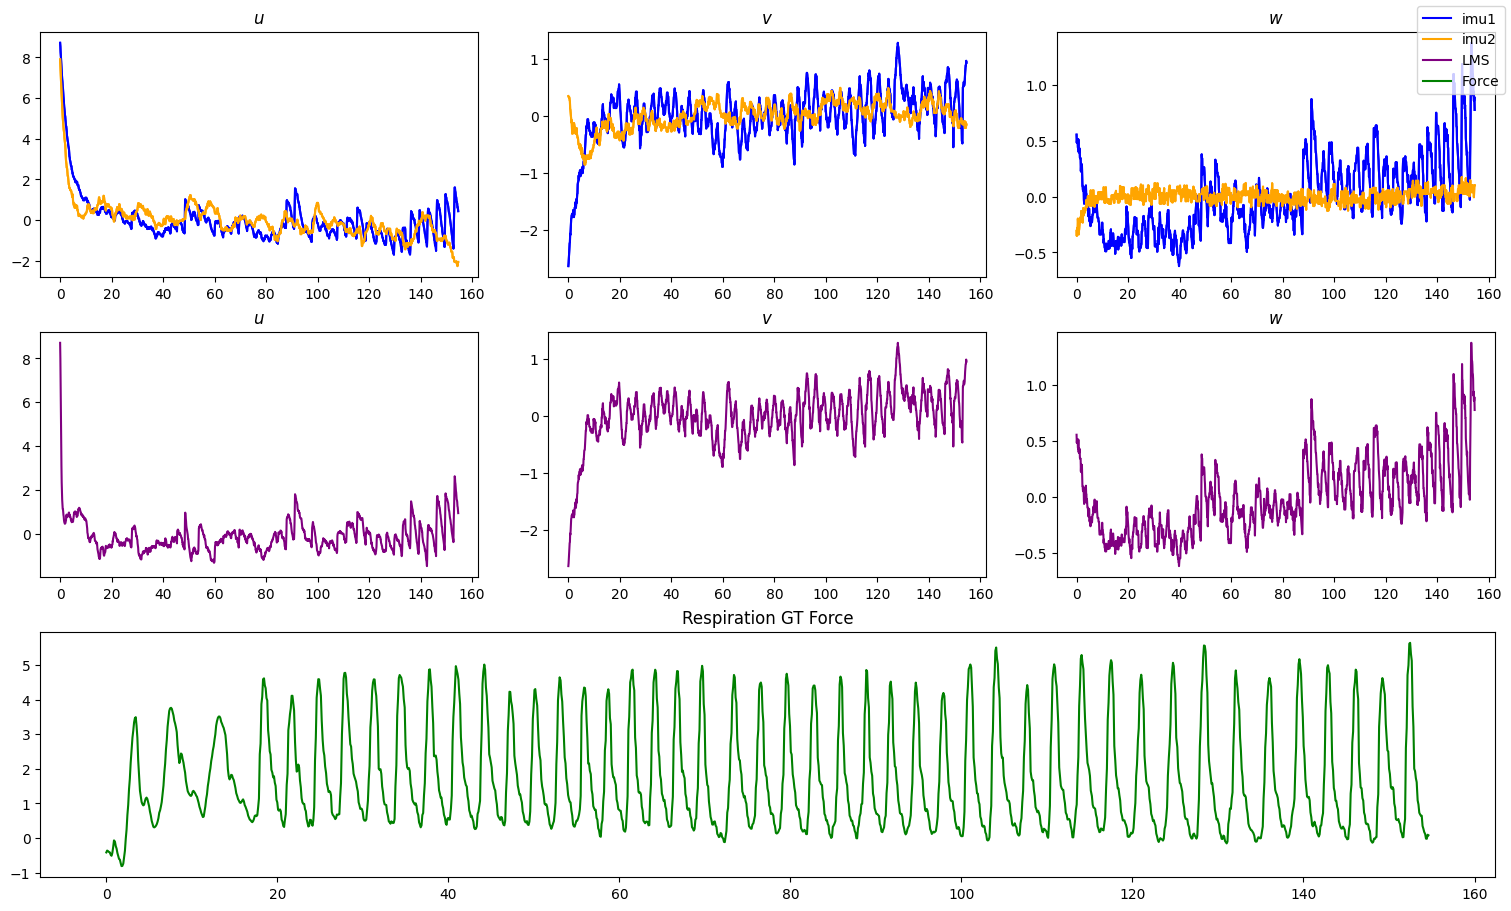

In [34]:
NTAPS = 5 # 10
LEARNING_RATE = 0.001 # 0.001

outputs_dict_LMS = {}
outputs_dict_LMS['method'] = 'LMS'
coefficients_dict_LMS = {}
coefficients_dict_LMS['method'] = 'LMS'

for col in euler_axes:
    d = euler_angles[sensor_names[0] + '_' + col] # IMU1 (desire signal with more RR info.)
    x = euler_angles[sensor_names[1] + '_' + col] # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_LMS[col] = y
    coefficients_dict_LMS[col] = coefficients_history

draw_anc_curve_multi_euler(data, euler_angles, outputs=[outputs_dict_LMS])
# draw_fir_coefficients_curve(data, coefficients=coefficients_dict_LMS)

# LMS + LS

LEARNING_RATE:1.7195365939033044e-05
LEARNING_RATE:3.444664310650731e-06
LEARNING_RATE:4.9418919412756164e-06


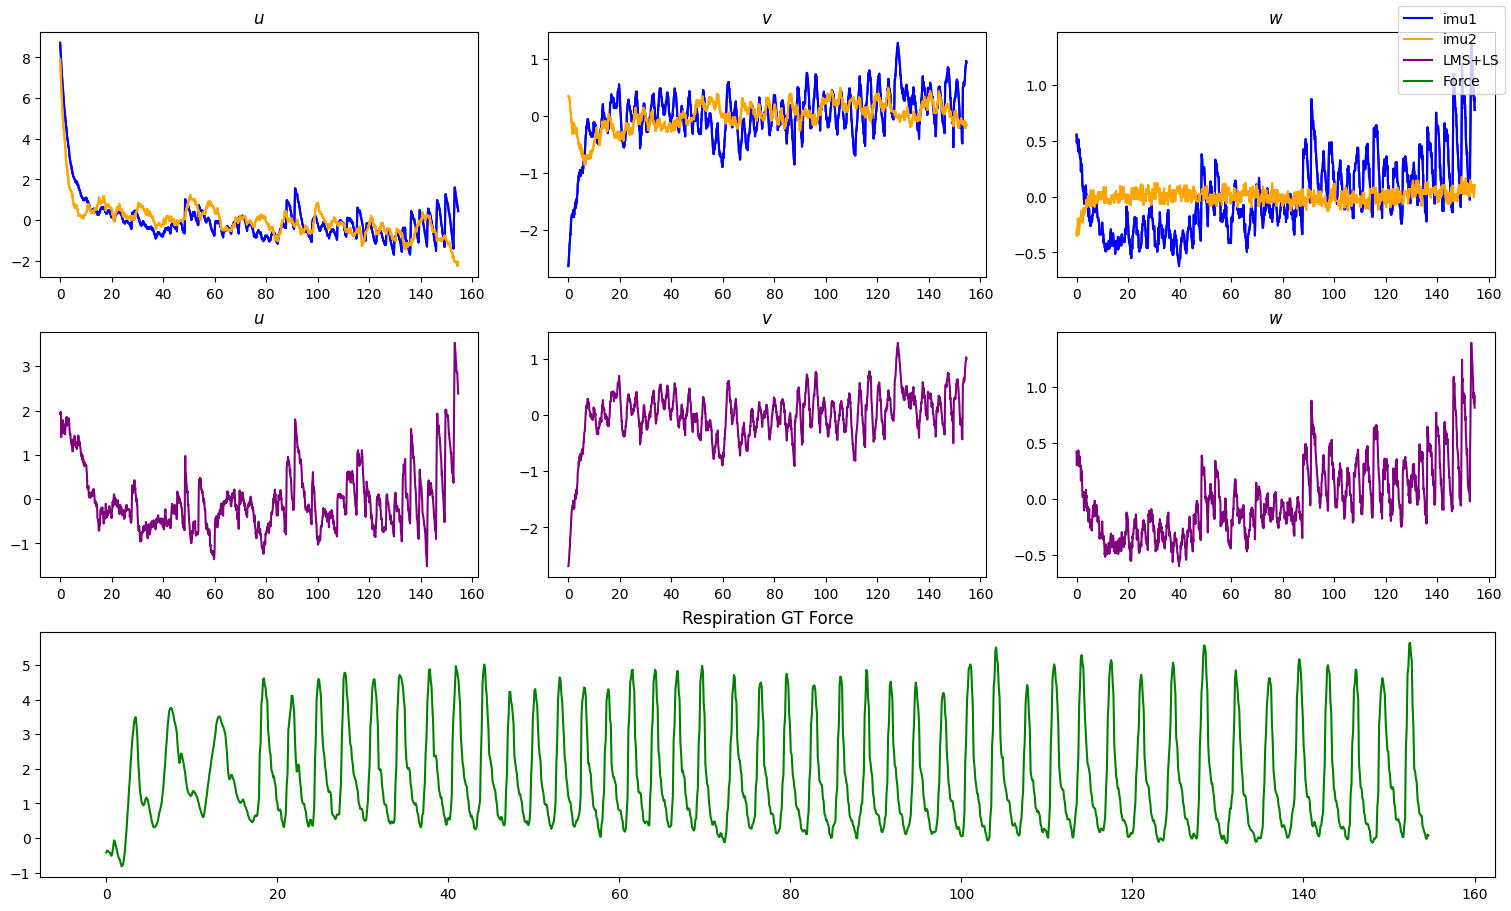

In [35]:
outputs_dict_LMSLS = {}
outputs_dict_LMSLS['method'] = 'LMS+LS'
coefficients_dict_LMSLS = {}
coefficients_dict_LMSLS['method'] = 'LMS+LS'

for col in euler_axes:
    d = euler_angles[sensor_names[0] + '_' + col] # IMU1 (desire signal with more RR info.)
    x = euler_angles[sensor_names[1] + '_' + col] # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))

    # Least Square Once
    f.ls(x, d)
    LEARNING_RATE = np.max(f.coefficients) / (5 * 1e4) # / 100
    print(f'LEARNING_RATE:{LEARNING_RATE}')
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_LMSLS[col] = y
    coefficients_dict_LMSLS[col] = coefficients_history

draw_anc_curve_multi_euler(data, euler_angles, outputs=[outputs_dict_LMSLS])
# draw_fir_coefficients_curve(data, coefficients=coefficients_dict_LMSLS)

# RLS

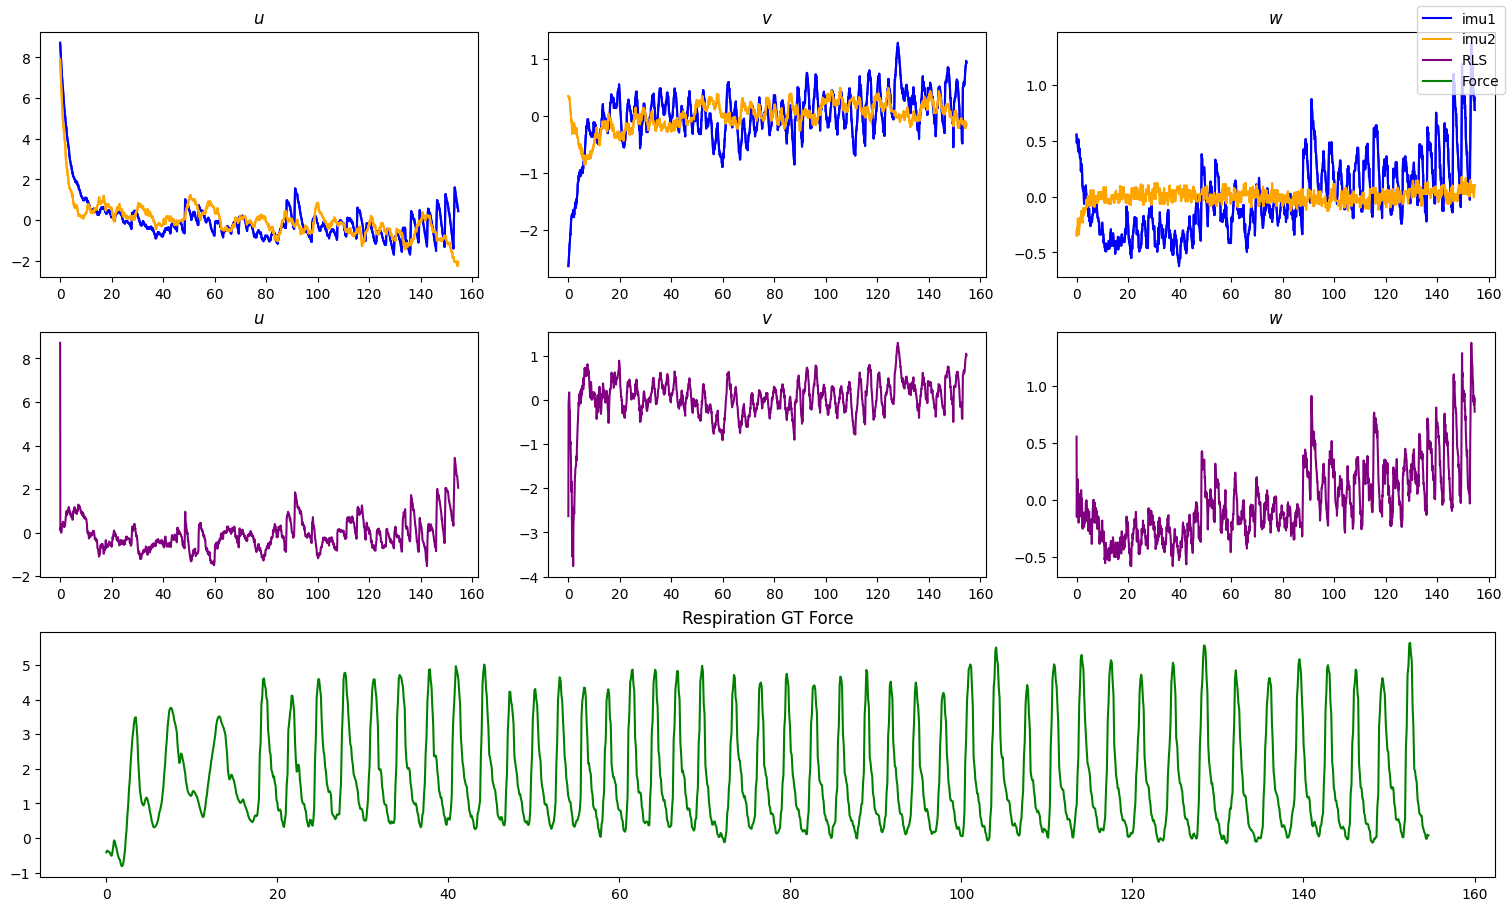

In [36]:
outputs_dict_RLS = {}
outputs_dict_RLS['method'] = 'RLS'
coefficients_dict_RLS = {}
coefficients_dict_RLS['method'] = 'RLS'

# RLS
delta = 1000 # 1
lam_rls = 0.9995 # 0.9995

for col in euler_axes:
    d = euler_angles[sensor_names[0] + '_' + col] # IMU1 (desire signal with more RR info.)
    x = euler_angles[sensor_names[1] + '_' + col] # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.rls(output_signal, delta=delta, lam=lam_rls)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_RLS[col] = y
    coefficients_dict_RLS[col] = coefficients_history

draw_anc_curve_multi_euler(data, euler_angles, outputs=[outputs_dict_RLS])
# draw_fir_coefficients_curve(data, coefficients=coefficients_dict_RLS)

# LRLS

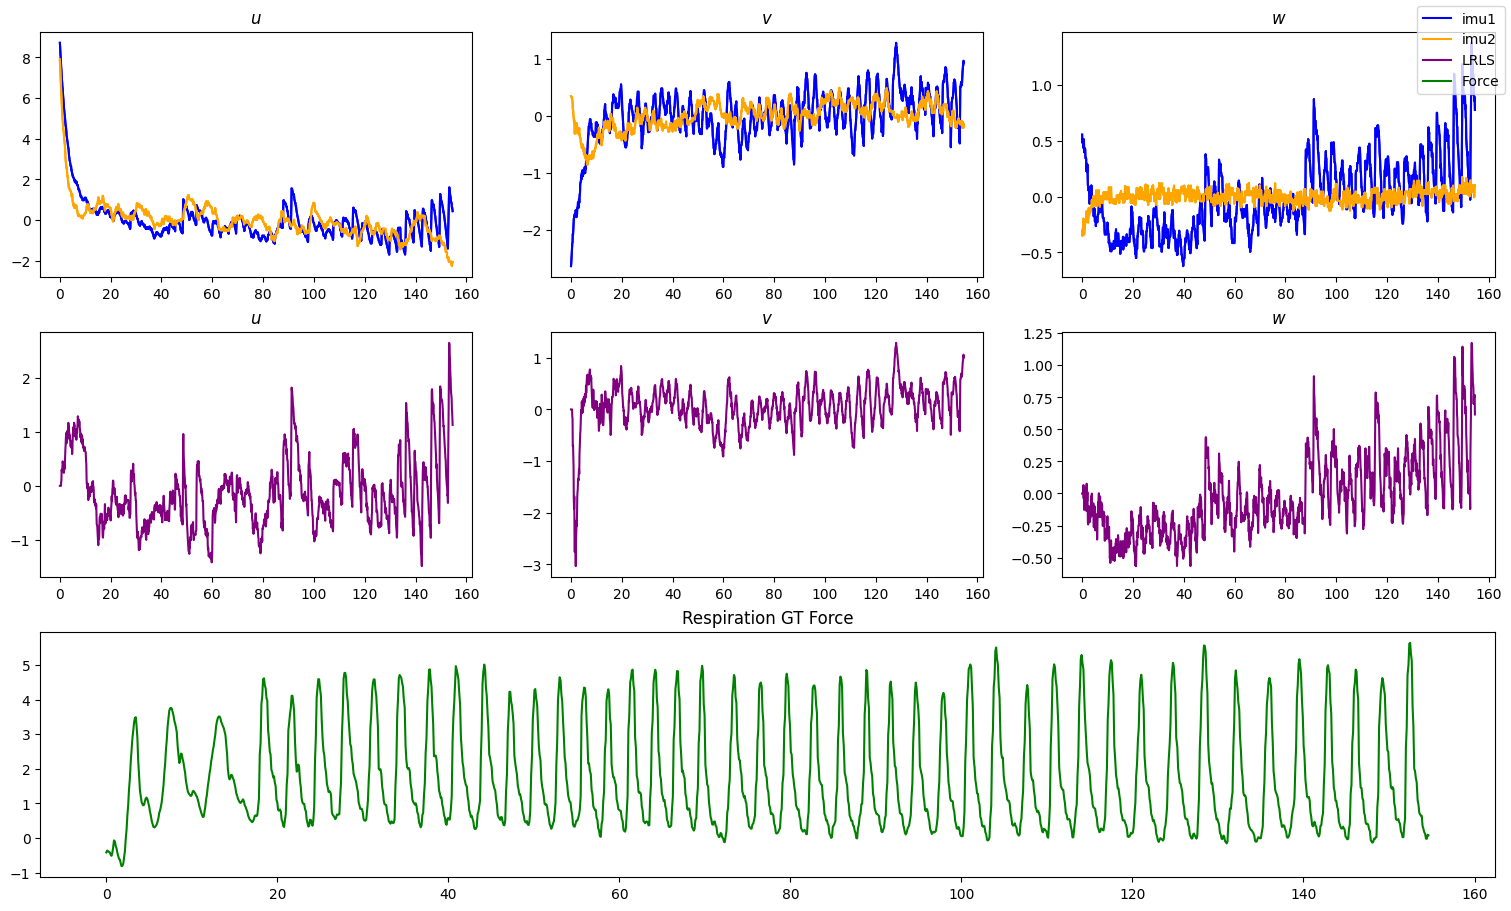

In [37]:
outputs_dict_LRLS = {}
outputs_dict_LRLS['method'] = 'LRLS'

# LRLS
epsilon = 1e-6
lam_lrls = 0.998 # 0.9995

for col in euler_axes:
    d = euler_angles[sensor_names[0] + '_' + col] # IMU1 (desire signal with more RR info.)
    x = euler_angles[sensor_names[1] + '_' + col] # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        output_signal = f.lrls(x=ref_noise, d=d[i], N= len(d), lam=lam_lrls)
        y[i] = output_signal
    
    outputs_dict_LRLS[col] = y

draw_anc_curve_multi_euler(data, euler_angles, outputs=[outputs_dict_LRLS])

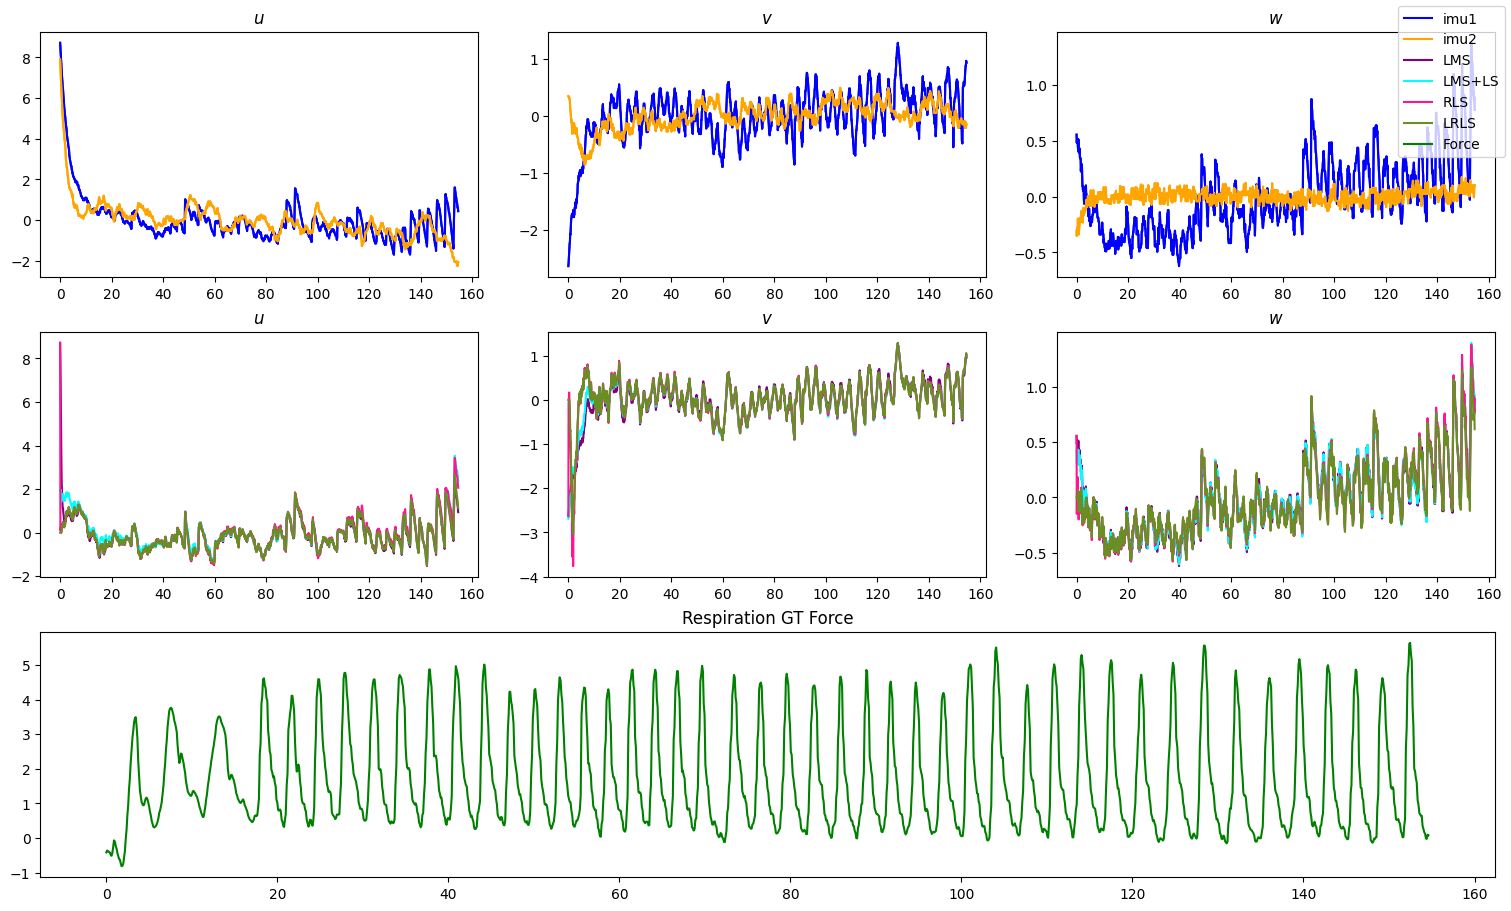

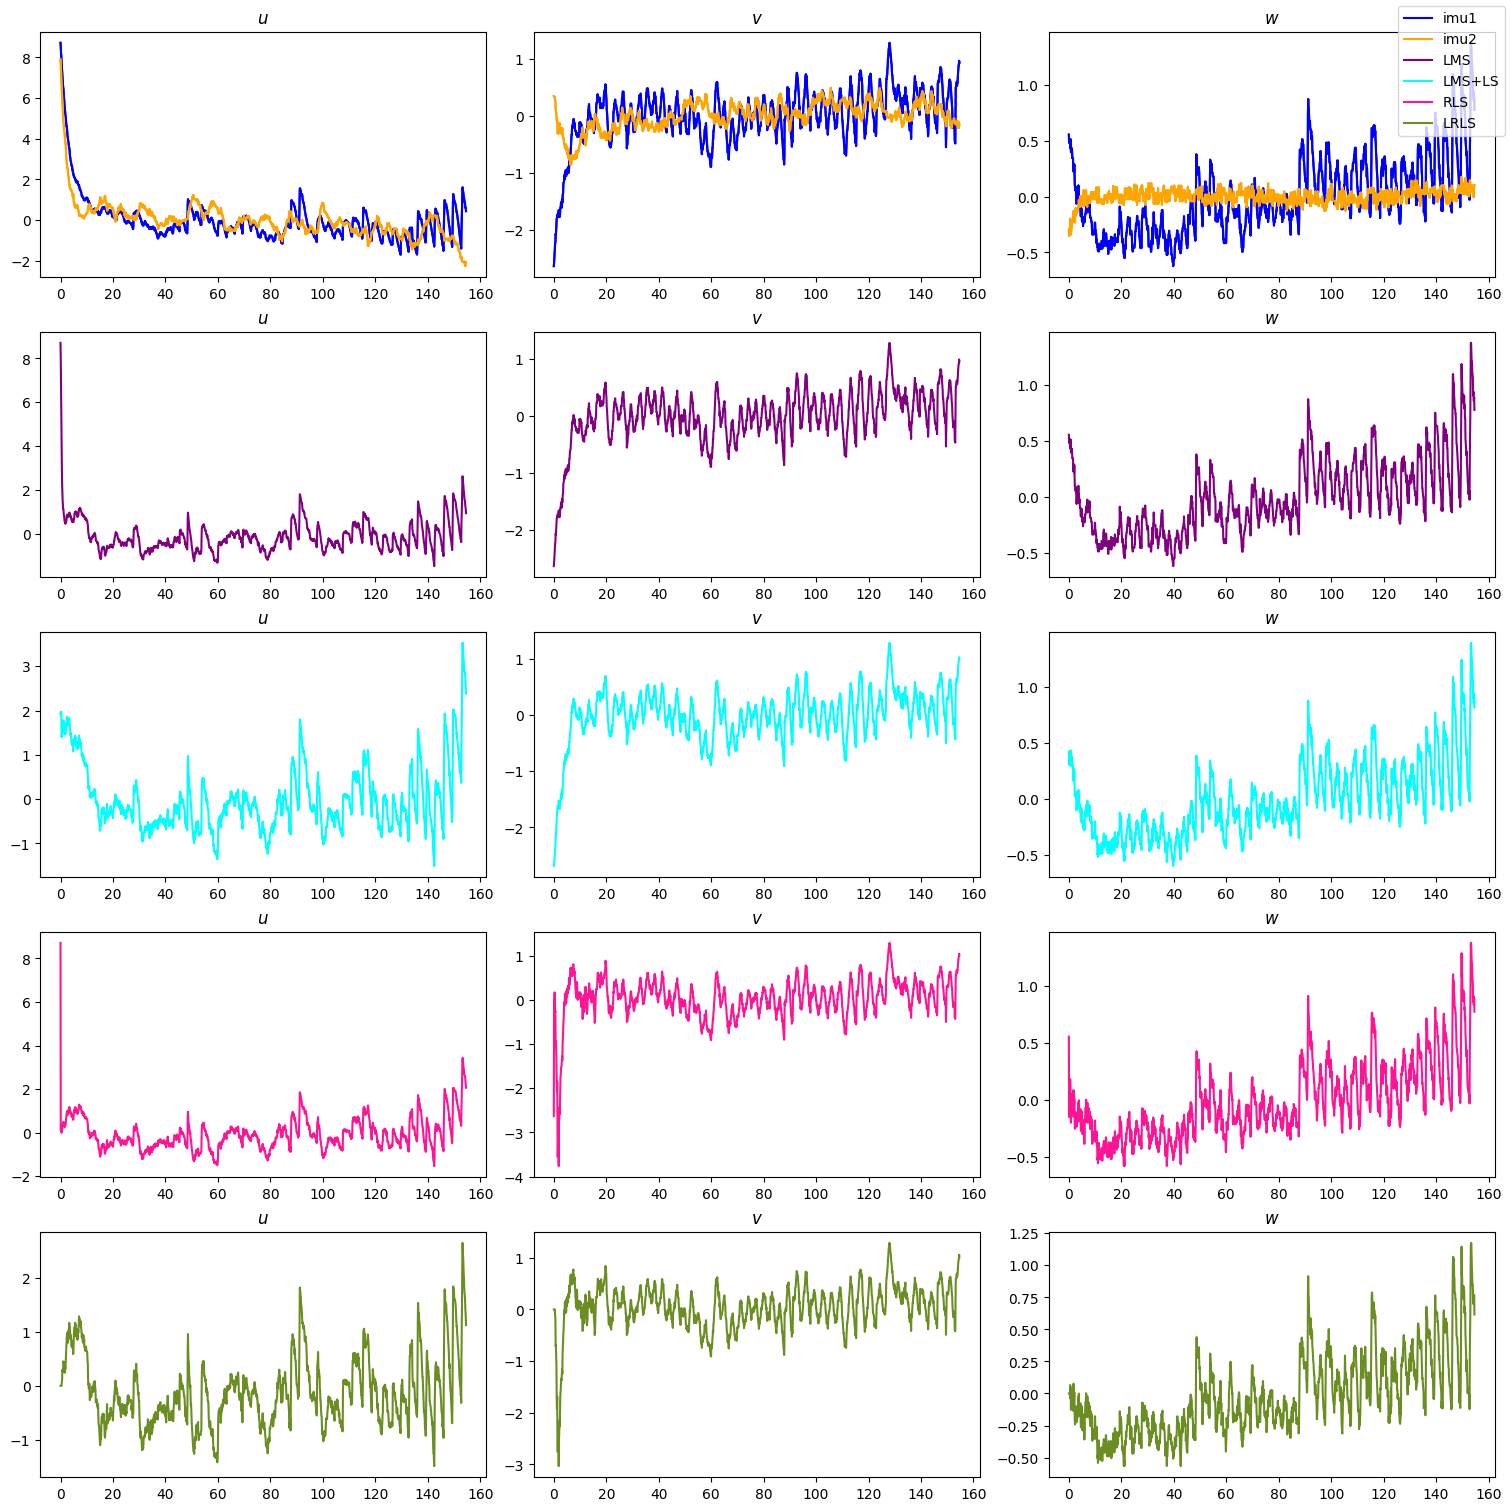

In [38]:
# Show all ANC results
draw_anc_curve_multi_euler(data, euler_angles, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS])
draw_anc_curve_multi_euler(data, euler_angles, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], overlap=False, show_gt=False)

# Auto-Correlation

In [39]:
def generate_gt_rr(force, window_size):
    

    return gt_rr

[  35   77   89  104  134  149  188  200  221  253  266  285  319  350
  361  386  417  451  481  494  512  541  570  599  628  655  681  711
  749  781  812  845  876  907  936  966  999 1031 1062 1099 1131 1164
 1199 1235 1273 1310 1320 1348 1359 1388 1424 1458 1491 1523 1535 1556]
[  34   77  105  135  188  221  254  285  319  351  386  418  452  483
  512  542  570  599  627  655  681  711  749  781  813  845  876  908
  936  967  999 1030 1062 1099 1132 1164 1199 1235 1273 1310 1349 1388
 1424 1458 1491 1523 1556]


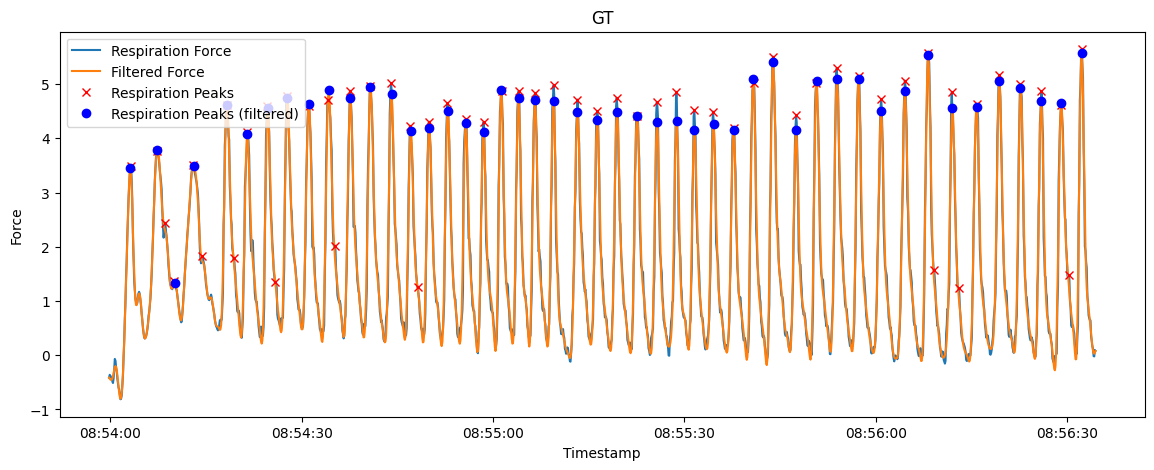

In [40]:
# Define GT RR as auto-correlation for RR Force (time-interval same as ANC output): Sliding Window
# NO peaks finding require

# peaks, _ = sg.find_peaks(data["Force"], height=6, distance=np.median(data["Force"]))
peaks, _ = sg.find_peaks(data["Force"], height=np.median(data["Force"]), distance=fs)
print(peaks)

# gt_filter = butter_filter(data["Force"], cutoff=0.33, fs=fs)
gt_filter = butter_filter(data["Force"], cutoff=1.0, fs=fs)
peaks_gt, _ = sg.find_peaks(gt_filter, height=np.median(gt_filter), distance=1.5 * fs)
print(peaks_gt)

plt.figure(figsize=(14, 5))
plt.subplot(1, 1, 1)
plt.plot(
    data.index,
    data["Force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    data.index,
    gt_filter,
    label="Filtered Force", # IMU1 RMS
)

plt.plot(
    data.index[peaks],
    data["Force"].iloc[peaks],
    "x",
    c='r',
    label="Respiration Peaks",
)

plt.plot(
    data.index[peaks_gt],
    gt_filter[peaks_gt],
    "o",
    c='b',
    label="Respiration Peaks (filtered)",
)

plt.title("GT")
plt.xlabel("Timestamp")
plt.ylabel("Force")
plt.legend()

plt.show()